In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset
from itertools import product, chain
import importlib

import trainer, data, models

/Users/ralph/.venvs/d2dl/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [3]:
importlib.reload(trainer)
importlib.reload(data)
importlib.reload(models)

<module 'models' from '/Users/ralph/projects/d2dl/models.py'>

In [4]:
kaggle_housing_dataset = data.kaggle_housing()

In [5]:
class LinearRegression(nn.Sequential):
    def __init__(
            self,
            output_bias_mean,
            output_bias_stddev,
            hidden_dim: int = 100,
            num_outputs: int = 1,
        ):
        super().__init__(
            nn.LazyLinear(hidden_dim),
            nn.ReLU(),
            nn.LazyLinear(hidden_dim),
            nn.ReLU(),
            nn.LazyLinear(hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, num_outputs)
        )

        nn.init.normal_(
            self[-1].bias, 
            mean=output_bias_mean,
            std=1.0
        ) 

    def forward_scaled(self, input):
        return torch.exp(self(input))

In [6]:
class RMSLELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()
        
    def forward(self, pred, actual):
        return torch.sqrt(self.mse(torch.log(pred + 1), torch.log(actual + 1)))

In [7]:
class RMSELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()
        
    def forward(self, pred, actual):
        return torch.sqrt(self.mse(pred, actual))

In [8]:
provider = lambda hyperparams: trainer.Trainer(
    model=LinearRegression(
        output_bias_mean=hyperparams.model["output_bias_mean"],
        output_bias_stddev=hyperparams.model["output_bias_stddev"],
        hidden_dim=hyperparams.model["hidden_dim"],
        num_outputs=1,
    ),
    dataset=kaggle_housing_dataset,
    # loss=RMSLELoss,
    loss=RMSELoss,
    opt=torch.optim.SGD,
    hyperparameters=hyperparams
)

In [27]:
model_trainer = provider(trainer.Hyperparameters(
    opt=dict(
        lr = 3e-3
    ),
    model=dict(
        output_bias_mean = kaggle_housing_dataset.train.dataframe["SalePrice"].mean(),
        output_bias_stddev = kaggle_housing_dataset.train.dataframe["SalePrice"].std(),
        hidden_dim = 300
    ),
    general=dict(
        num_epochs = 200,
        batch_size = 64
    )
))

/Users/ralph/.venvs/d2dl/lib/python3.9/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [28]:
train_result = model_trainer.train(16)

loss tensor(13.3269, grad_fn=<MeanBackward0>) tensor(12.0617) tensor(1.3059, grad_fn=<SqrtBackward0>)
loss tensor(13.3189, grad_fn=<MeanBackward0>) tensor(11.9479) tensor(1.4339, grad_fn=<SqrtBackward0>)
loss tensor(13.3151, grad_fn=<MeanBackward0>) tensor(12.0542) tensor(1.3133, grad_fn=<SqrtBackward0>)
loss tensor(13.3084, grad_fn=<MeanBackward0>) tensor(11.9056) tensor(1.4626, grad_fn=<SqrtBackward0>)
loss tensor(13.3026, grad_fn=<MeanBackward0>) tensor(12.0108) tensor(1.3536, grad_fn=<SqrtBackward0>)
loss tensor(13.2989, grad_fn=<MeanBackward0>) tensor(12.0278) tensor(1.3238, grad_fn=<SqrtBackward0>)
loss tensor(13.2927, grad_fn=<MeanBackward0>) tensor(12.0345) tensor(1.3371, grad_fn=<SqrtBackward0>)
loss tensor(13.2854, grad_fn=<MeanBackward0>) tensor(12.0919) tensor(1.2554, grad_fn=<SqrtBackward0>)
loss tensor(13.2769, grad_fn=<MeanBackward0>) tensor(11.9523) tensor(1.3724, grad_fn=<SqrtBackward0>)
loss tensor(13.2737, grad_fn=<MeanBackward0>) tensor(11.9576) tensor(1.3703, grad_

In [29]:
train_result

,train,val
0,1.305909,1.353659
1,1.323813,1.288336
2,1.261861,1.239818
3,1.329529,1.335284
4,1.150886,1.221271
...,...,...
195,0.155711,0.120527
196,0.141257,0.189416
197,0.139103,0.141789
198,0.122729,0.148662


<Axes: >

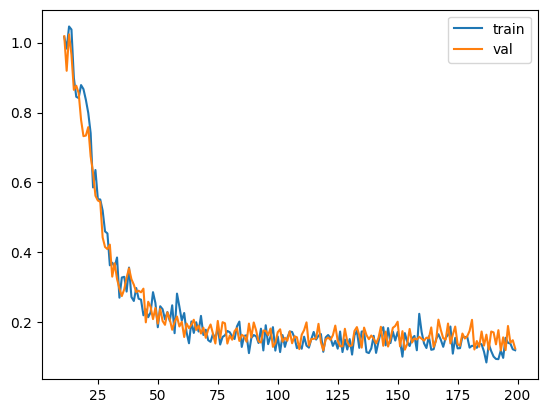

In [30]:
train_result[1:][10:].plot()

In [31]:
val_x = torch.stack([
    kaggle_housing_dataset.val[i][0]
    for i in range(len(kaggle_housing_dataset.val))
])

In [32]:
val_y = torch.stack([
    kaggle_housing_dataset.val[i][1]
    for i in range(len(kaggle_housing_dataset.val))
])

In [33]:
model_y = model_trainer.model(val_x)

In [34]:
val_df = pd.DataFrame(
    torch.stack([
        torch.exp(torch.flatten(model_y.detach())),
        torch.exp(torch.flatten(val_y))
    ], dim = 1),
    columns=["pred", "val"]
)

In [35]:
val_df

,pred,val
0,243299.875000,254899.984375
1,110280.101562,119000.046875
2,106731.296875,124000.007812
3,149622.343750,143999.953125
4,118609.726562,106000.031250
...,...,...
287,264959.531250,327999.875000
288,122878.250000,132500.046875
289,108696.968750,119000.046875
290,131237.421875,129999.976562


<Axes: xlabel='pred', ylabel='val'>

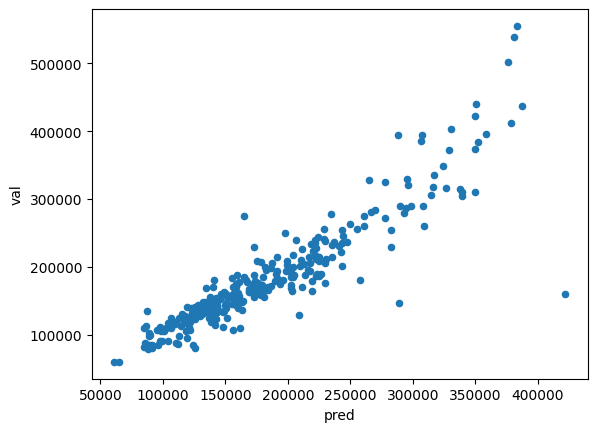

In [44]:
val_df.plot(kind="scatter", x="pred", y="val")

In [37]:
loss = RMSELoss()

In [38]:
loss(
    torch.flatten(model_y.detach()),
    torch.flatten(val_y)
)

tensor(0.1488)

In [39]:
test_y = torch.stack([
    kaggle_housing_dataset.test[i][0]
    for i in range(len(kaggle_housing_dataset.test))
])

In [40]:
preds = model_trainer.model.forward_scaled(test_y)

In [41]:
test_preds_df = pd.DataFrame({
    "Id": kaggle_housing_dataset.test.dataframe["Id"],
    "SalePrice": torch.flatten(preds).detach()
})

In [43]:
test_preds_df.to_csv("datasets/kaggle_housing/test_preds/20230107-v5.csv", index=False)